# Initializing


## Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2 as cv
from scipy.ndimage import gaussian_filter
import random
from google.colab import drive
import os




drive.mount('/content/drive')
# %run '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Fourier_Test/Watermarking_Classes.ipynb'
%run '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/MyWatermarkinClasses.ipynb'


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ** Hyper_Parameter

In [ ]:
training_epochs = 12



num_train_samples = 22_000
img_size = 128


# Mask Ratio
mask_ratio = 0.5


## Method
# Method = "PRNG"
# Method = "Wave"
Method = "Guassian"


## PRNG Algorithm
# PRNG_Agorithm = "Mersenne"
# PRNG_Agorithm = "WELL512"
# PRNG_Agorithm = "LCG"
PRNG_Agorithm = "MCG"



## Augmentation
min_noise_strength = 0.05
max_noise_strength = 2

## Host Image

In [ ]:
folder_path = '/content/drive/My Drive/Colab Notebooks/Image/Host_Image_128'

image_array = []
target_size = (128, 128)  # Resize to desired shape (width, height)

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(folder_path, filename)
        my_image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        im = my_image.astype(np.float32)
        im = np.expand_dims(im, axis=-1)
        im = im / 255.0
        im = im[:,:,0]
        image_array.append(im)

# PRNG_Functions

## Mersenne_Twister

In [ ]:
def Mersenne_Twister_PRNG(image_size, seed):
    """
    Generate a 2D pseudo-random image using Mersenne Twister.

    Parameters:
    - width: int, image width
    - height: int, image height
    - seed: int or None, seed for reproducibility

    Returns:
    - 2D numpy array with values in [0, 1]
    """
    rng = np.random.default_rng(seed)  # uses MT19937 by default
    image = rng.random((image_size, image_size))  # 2D array of floats in [0,1)
    return image

## LCG

In [ ]:
def LCG_PRNG(img_size, seed, a=1664525, c=1013904223, m=2**32):
    """
    Generate a 2D pseudo-random image using a Linear Congruential Generator (LCG).

    Parameters:
    - width: int, image width
    - height: int, image height
    - seed: int, initial seed
    - a: int, multiplier (default 1664525)
    - c: int, increment (default 1013904223)
    - m: int, modulus (default 2**32)

    Returns:
    - 2D numpy array of shape (height, width) with values in [0,1)
    """
    x = seed
    image = np.zeros((img_size, img_size), dtype=np.float32)

    for i in range(img_size):
        for j in range(img_size):
            x = (a * x + c) % m
            image[i, j] = x / m  # normalize to [0,1)

    return image

## MCG

In [ ]:
def MCG_PRNG(img_size, seed, a=1664525, c=0, m=2**32):
    """
    Generate a 2D pseudo-random image using a Linear Congruential Generator (LCG).

    Parameters:
    - width: int, image width
    - height: int, image height
    - seed: int, initial seed
    - a: int, multiplier (default 1664525)
    - c: int, increment (default 1013904223)
    - m: int, modulus (default 2**32)

    Returns:
    - 2D numpy array of shape (height, width) with values in [0,1)
    """
    x = seed
    image = np.zeros((img_size, img_size), dtype=np.float32)

    for i in range(img_size):
        for j in range(img_size):
            x = (a * x + c) % m
            image[i, j] = x / m  # normalize to [0,1)

    return image

## WELL

In [ ]:
class WELL512a:
    def __init__(self, seed):
        # Internal state: 16 unsigned 32-bit integers
        self.state = np.zeros(16, dtype=np.uint32)
        self.index = 0

        # Initialize state with seed
        np.random.seed(seed)
        self.state[:] = np.random.randint(0, 2**32, size=16, dtype=np.uint32)

    def next_uint32(self):
        a, b, c, d = 16, 13, 9, 15
        i = self.index
        z0 = self.state[(i + 15) & 0x0f]
        z1 = self.state[i] ^ (self.state[i] << 16) ^ (self.state[(i + 13) & 0x0f] << 15)
        z2 = self.state[(i + 9) & 0x0f] ^ (self.state[(i + 9) & 0x0f] >> 11)
        self.state[i] = z1 ^ z2
        self.index = (i + 15) & 0x0f
        return self.state[i] + z0  # combine for output

    def next_float(self):
        # Normalize to [0,1)
        return self.next_uint32() / 2**32

def WELL512_PRNG(img_size, seed):
    """
    Generate 2D pseudo-random image using WELL512a generator.
    """
    rng = WELL512a(seed)
    image = np.zeros((img_size, img_size), dtype=np.float32)
    for i in range(img_size):
        for j in range(img_size):
            image[i, j] = rng.next_float()
    return image

## Guassian

In [ ]:
def Gaussian_PRNG(img_size, mean, variance):

    sigma = np.sqrt(variance)

    # Generate noise using normal distribution
    noise = np.random.normal(mean, sigma, (img_size, img_size))

    # Normalize to 0–255 and convert to uint8
    noise_normalized = 255 * (noise - noise.min()) / (noise.max() - noise.min())
    noise_uint8 = noise_normalized.astype(np.uint8)

    return noise_uint8


## Wave_Pattern

In [ ]:
def created_wave_pattern(image_size, freq):
    freq_variation = 1.5
    x = np.linspace(0, 2 * np.pi, image_size)
    y = np.linspace(0, 2 * np.pi, image_size)
    X, Y = np.meshgrid(x, y)

    # Apply small random frequency variations
    freq_x = freq + np.random.uniform(-freq_variation, freq_variation)
    freq_y = freq + np.random.uniform(-freq_variation, freq_variation)

    # Random phase shifts
    phase_shift_x = np.random.uniform(0, 2 * np.pi)
    phase_shift_y = np.random.uniform(0, 2 * np.pi)

    # Generate wave pattern with varied frequency and phase shift
    wave = np.sin(freq_x * X + phase_shift_x) * np.cos(freq_y * Y + phase_shift_y)

    return normalized_image(wave)


def normalized_image(im):
    # Find the minimum and maximum values in the matrix
    min_value = im.min()
    max_value = im.max()

    # Apply min-max normalization to each element
    normalized_im = (im - min_value) / (max_value - min_value)

    return normalized_im

# Mask_Functions

In [ ]:
def Created_Mask(im_size , mask_ratio):
  rows, cols = im_size, im_size
  crow, ccol = rows // 2, cols // 2
  mask = np.zeros((rows, cols), np.uint8)
  mask_radius = int(mask_ratio * im_size)
  cv.circle(mask, (ccol, crow), mask_radius, 1, thickness=-1)
  return mask


def Created_Masked_PN(pn, mask_ratio):

  image_size = pn.shape[0]

  fft_hybrid = np.fft.fft2(pn)
  fft_hybrid_shifted = np.fft.fftshift(fft_hybrid)

  mask = Created_Mask(image_size, mask_ratio)

  high_freqs = fft_hybrid_shifted * (1 - mask)
  reconstructed_pn = np.fft.ifft2(np.fft.ifftshift(high_freqs))
  reconstructed_pn_abs = np.abs(reconstructed_pn)

  epsilon = 1e-8
  spectrum = np.log(reconstructed_pn_abs + epsilon)

  return spectrum

# Created_Data

## Augmentation

In [ ]:
def add_random_noise(image, noise_strength):

  noise = np.random.normal(loc=0, scale=1, size=image.shape)  # Generate standard normal noise
  noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))  # Normalize noise to [0,1]
  noise = 2 * noise_strength * (noise - 0.5)  # Scale to [-noise_strength, noise_strength]

  # Apply Gaussian blur to create correlated noise
  correlated_noise = gaussian_filter(noise, sigma=1)

  # Add noise to the image and clip to valid range
  image_noisy = image + correlated_noise
  image_noisy = np.clip(image_noisy, 0, 1)
  return image_noisy

## Test

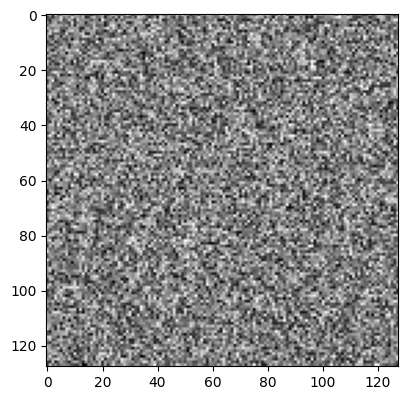

In [ ]:
pn1 = Mersenne_Twister_PRNG(img_size, 1)
pn2 = Mersenne_Twister_PRNG(img_size, 2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pn1 - pn2, cmap='gray')


In [ ]:
## Created PRNG Pattern
##
def created_prng_data(samples_num, width, height, algorithm, min_noise_strength, max_noise_strength):

  data = np.zeros((samples_num, height, width))

  for i in range(samples_num):

    seed = np.random.randint(0, 4294967295)

    if(algorithm == "Mersenne"):
      pn = Mersenne_Twister_PRNG(img_size, seed)
      temp_data = Created_Masked_PN(pn , mask_ratio)

    elif(algorithm == "WELL512"):
      pn = WELL512_PRNG(img_size, seed)
      temp_data = Created_Masked_PN(pn , mask_ratio)

    elif(algorithm == "LCG"):
      pn = LCG_PRNG(img_size, seed)
      temp_data = Created_Masked_PN(pn , mask_ratio)

    elif(algorithm == "MCG"):
      pn = MCG_PRNG(img_size, seed)
      temp_data = Created_Masked_PN(pn , mask_ratio)


    # Created Clean Data
    if(random.randint(0, 1) == 0):
      data[i] = temp_data

    # Created Noisy Data
    else:
      noise_strength = np.random.uniform(min_noise_strength, max_noise_strength)
      data[i] = add_random_noise(temp_data, noise_strength)

  return data


## Created Wave Pattern
def created_wave_data(samples_num, img_size, frq, min_noise, max_noise):

  data = np.zeros((samples_num, img_size, img_size))

  for i in range(samples_num):

    index = np.random.randint(0, len(image_array))
    image = image_array[index]

    pn = created_wave_pattern(img_size, frq)

    # Clean Data
    if(random.randint(0, 1) == 0):
      data[i] = Created_Masked_PN(pn , mask_ratio)

    # Noisy Data
    else:
      tr = Transmitter(image, pn, mask_ratio)
      watermarked = tr.Watermarking()

      noise_strength = np.random.uniform(min_noise, max_noise)
      noisy_watermarked = add_random_noise(watermarked , noise_strength)

      data[i] = Created_Masked_PN(noisy_watermarked , mask_ratio)

  return data


## Created Wave Pattern
def created_guassian_data(samples_num, img_size, mean, var, min_noise, max_noise):

  data = np.zeros((samples_num, img_size, img_size))

  for i in range(samples_num):

    index = np.random.randint(0, len(image_array))
    image = image_array[index]

    pn = Gaussian_PRNG(img_size, mean, var)

    # Clean Data
    if(random.randint(0, 1) == 0):
      data[i] = Created_Masked_PN(pn , mask_ratio)

    # Noisy Data
    else:
      tr = Transmitter(image, pn, mask_ratio)
      watermarked = tr.Watermarking()

      noise_strength = np.random.uniform(min_noise, max_noise)
      noisy_watermarked = add_random_noise(watermarked , noise_strength)

      data[i] = Created_Masked_PN(noisy_watermarked , mask_ratio)

  return data


## Created Data
if(Method == "PRNG"):
  print(f"{PRNG_Agorithm} Algorithm is selected")
  data_class1 = created_prng_data(num_train_samples // 4, img_size, img_size, PRNG_Agorithm, min_noise_strength, max_noise_strength)
  data_class2 = created_prng_data(num_train_samples // 4, img_size, img_size, PRNG_Agorithm, min_noise_strength, max_noise_strength)
  data_class3 = created_prng_data(num_train_samples // 4, img_size, img_size, PRNG_Agorithm, min_noise_strength, max_noise_strength)
  data_class4 = created_prng_data(num_train_samples // 4, img_size, img_size, PRNG_Agorithm, min_noise_strength, max_noise_strength)

elif(Method == "Wave"):
  print("Wave Pattern Algorithm is selected")
  data_class1 = created_wave_data(num_train_samples // 4, img_size, 5, min_noise_strength, max_noise_strength)
  data_class2 = created_wave_data(num_train_samples // 4, img_size, 10, min_noise_strength, max_noise_strength)
  data_class3 = created_wave_data(num_train_samples // 4, img_size, 15, min_noise_strength, max_noise_strength)
  data_class4 = created_wave_data(num_train_samples // 4, img_size, 20, min_noise_strength, max_noise_strength)

elif(Method == "Guassian"):
  print("Guassian Pattern Algorithm is selected")
  data_class1 = created_guassian_data(num_train_samples // 4, img_size, 0, 0.1, min_noise_strength, max_noise_strength)
  data_class2 = created_guassian_data(num_train_samples // 4, img_size, 0, 0.3, min_noise_strength, max_noise_strength)
  data_class3 = created_guassian_data(num_train_samples // 4, img_size, 0, 0.5, min_noise_strength, max_noise_strength)
  data_class4 = created_guassian_data(num_train_samples // 4, img_size, 0, 0.7, min_noise_strength, max_noise_strength)


Guassian Pattern Algorithm is selected


## Test

In [ ]:
# temp_pn = created_wave_pattern(img_size, 10)
temp_pn = created_guassian_data(1, 128, 0, 10, 0, 0.001)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(temp_pn[0], cmap='gray')


# plt.subplot(1, 2, 2)
# plt.imshow(data_class2[0], cmap='gray')
# plt.show()


NameError: name 'created_guassian_data' is not defined

# Fine Tuning

## Initializing

In [ ]:
# Step 1: Combine data and create labels
X = np.concatenate([data_class1, data_class2, data_class3, data_class4], axis=0)  # shape: [20000, 128, 128]
y = np.concatenate([
    np.zeros(num_train_samples//4),
    np.ones(num_train_samples//4),
    np.full(num_train_samples//4, 2),
    np.full(num_train_samples//4, 3)
], axis=0)

# Step 2: Add channel dim for PyTorch: [N, 1, 128, 128]
X = np.expand_dims(X, axis=1).astype(np.float32)
y = y.astype(np.longlong)

# Step 3: Train/val/test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# Step 4: Wrap in PyTorch datasets
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_ds   = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_ds  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

# Step 5: DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

# Step 6: Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Modify for 1-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify for 4 output classes
model.fc = nn.Linear(model.fc.in_features, 4)

# Step 7: Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 25.7MB/s]


## Training

In [ ]:
loss_history = []
accuracy_history = []

for epoch in range(training_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        outputs = model(xb)
        loss = criterion(outputs, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == yb).sum().item()
        total += yb.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total

    loss_history.append(avg_loss)
    accuracy_history.append(train_acc)

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Train Accuracy = {train_acc:.4f}")


Epoch 1: Loss = 1.4331, Train Accuracy = 0.2486
Epoch 2: Loss = 1.3675, Train Accuracy = 0.3148
Epoch 3: Loss = 1.2827, Train Accuracy = 0.4025
Epoch 4: Loss = 1.0255, Train Accuracy = 0.5704
Epoch 5: Loss = 0.5580, Train Accuracy = 0.7903
Epoch 6: Loss = 0.2340, Train Accuracy = 0.9204
Epoch 7: Loss = 0.1266, Train Accuracy = 0.9586
Epoch 8: Loss = 0.0751, Train Accuracy = 0.9771
Epoch 9: Loss = 0.0624, Train Accuracy = 0.9780
Epoch 10: Loss = 0.0831, Train Accuracy = 0.9725
Epoch 11: Loss = 0.1030, Train Accuracy = 0.9638
Epoch 12: Loss = 0.0857, Train Accuracy = 0.9711


## Plot

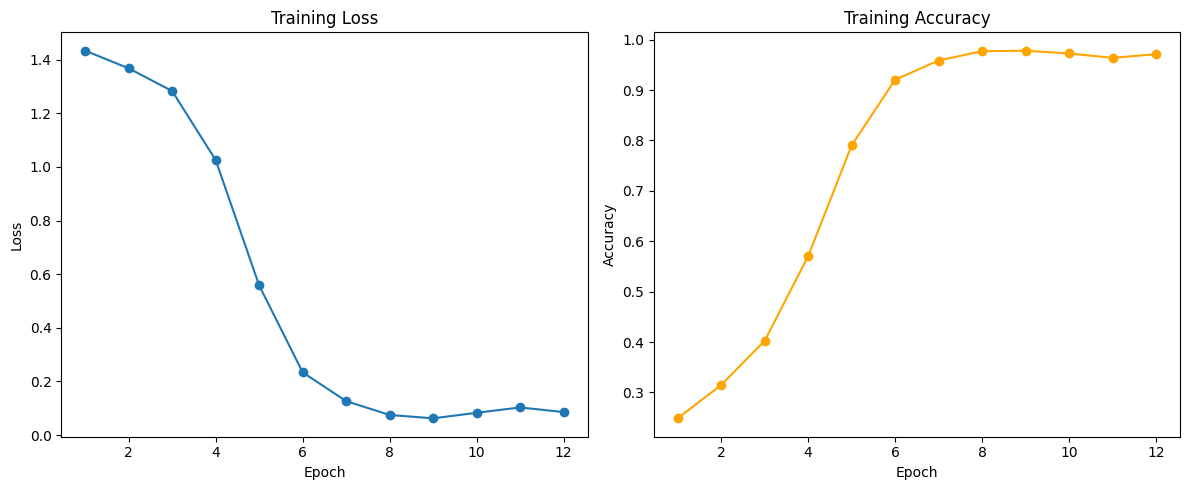

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, training_epochs+1), loss_history, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, training_epochs+1), accuracy_history, marker='o', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

## Confusion Matrix


Classification Report:

              precision    recall  f1-score   support

           0     0.2464    0.2267    0.2361       825
           1     0.2599    0.2861    0.2724       825
           2     0.2596    0.2776    0.2683       825
           3     0.2583    0.2352    0.2462       825

    accuracy                         0.2564      3300
   macro avg     0.2561    0.2564    0.2557      3300
weighted avg     0.2561    0.2564    0.2557      3300



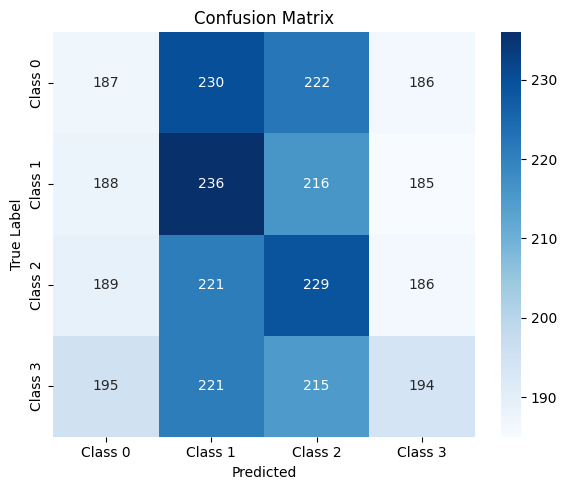

In [ ]:

# Step 1: Run model on test set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(yb.cpu().numpy())

# Step 2: Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Optional: Print classification report
print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, digits=4))

# Step 3: Visualize
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
